In [ ]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")
EXT_DIR      = PROJECT_ROOT / "data" / "external"
EXT_DIR.mkdir(parents=True, exist_ok=True)

out_path = EXT_DIR / "gichelle_sarimax_baseline.csv"

data = [
    # area, cabang_full, sku, RMSE_train, RMSE_test (Juni–Okt 2024)
    ("1A", "02A-GDWMS", "BUVW001KSW", 1596.83, 1374.80),
    ("1B", "05A-GDWMS", "BUVW001KSW", 1719.00,  653.75),
    ("2",  "13A-GDWMS", "DOPQ001K002", 2467.93, 1311.26),
    ("3",  "13I-GDWMS", "BUVW001KSW", 5687.70, 7161.30),
    ("4",  "14A-GDWMS", "BUVW001KSW", 1548.84, 1645.25),
    ("5",  "16C-GDWMS", "DOPQ001K009", 1672.50, 2335.16),
    ("6",  "29A-GDWMS", "BUVW001KSW", 2274.75,  823.00),
    ("7",  "23A-GDWMS", "BUVW001KSW", 2232.67, 1888.96),
    ("8",  "17A-GDWMS", "DOPQ001K002",  862.36,  438.16),
]

df = pd.DataFrame(
    data,
    columns=["area", "cabang_full", "sku", "RMSE_train", "RMSE_test"]
)

df["cabang"] = df["cabang_full"].str[:3]
df["model"]  = "SARIMAX_Gichelle_2025"
df["source"] = "Gichelle_thesis_table"

df_out = df[
    [
        "area",
        "cabang",
        "cabang_full",
        "sku",
        "model",
        "RMSE_train",
        "RMSE_test",
        "source",
    ]
]

df_out.to_csv(out_path, index=False)
print("Saved:", out_path)
print(df_out)


Saved: D:\Documents\Skripsi\demand-forecasting\data\external\gichelle_sarimax_baseline.csv
  area cabang cabang_full          sku                  model  RMSE_train  \
0   1A    02A   02A-GDWMS   BUVW001KSW  SARIMAX_Gichelle_2025     1596.83   
1   1B    05A   05A-GDWMS   BUVW001KSW  SARIMAX_Gichelle_2025     1719.00   
2    2    13A   13A-GDWMS  DOPQ001K002  SARIMAX_Gichelle_2025     2467.93   
3    3    13I   13I-GDWMS   BUVW001KSW  SARIMAX_Gichelle_2025     5687.70   
4    4    14A   14A-GDWMS   BUVW001KSW  SARIMAX_Gichelle_2025     1548.84   
5    5    16C   16C-GDWMS  DOPQ001K009  SARIMAX_Gichelle_2025     1672.50   
6    6    29A   29A-GDWMS   BUVW001KSW  SARIMAX_Gichelle_2025     2274.75   
7    7    23A   23A-GDWMS   BUVW001KSW  SARIMAX_Gichelle_2025     2232.67   
8    8    17A   17A-GDWMS  DOPQ001K002  SARIMAX_Gichelle_2025      862.36   

   RMSE_test                 source  
0    1374.80  Gichelle_thesis_table  
1     653.75  Gichelle_thesis_table  
2    1311.26  Gichelle_t

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")

DATASET15_DIR = PROJECT_ROOT / "data" / "dataset_15"
EXT_DIR       = PROJECT_ROOT / "data" / "external"

SARIMAX_DIR   = PROJECT_ROOT / "outputs" / "sarimax_15_log_trainselect"
sar_path = SARIMAX_DIR / "sarimax_15_log_trainselect_metrics.csv"
LGBM_DIR      = PROJECT_ROOT / "outputs" / "lgbm_15_clusters_tweedie_noleak"

TFT_DIR       = PROJECT_ROOT / "outputs"

OUT_DIR       = PROJECT_ROOT / "outputs" / "model_eval_4models"
OUT_DIR.mkdir(parents=True, exist_ok=True)

panel15 = pd.read_csv(
    DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv",
    usecols=["area", "cabang", "sku"]
).drop_duplicates()

def attach_area(df: pd.DataFrame) -> pd.DataFrame:
    return df.merge(panel15, on=["cabang", "sku"], how="left")

g_path = EXT_DIR / "gichelle_sarimax_baseline.csv"
g_df = pd.read_csv(g_path)

if "RMSE_test" not in g_df.columns:
    raise ValueError("Kolom 'RMSE_test' tidak ditemukan di gichelle_sarimax_baseline.csv")

g_metrics = g_df[["area", "cabang", "sku", "RMSE_test"]].copy()
g_metrics["model"] = "SARIMAX_Gichelle"

SARIMAX_DIR = PROJECT_ROOT / "outputs" / "sarimax_15_log_trainselect"
sar_path    = SARIMAX_DIR / "sarimax_15_log_trainselect_metrics.csv"

sar_df = pd.read_csv(sar_path)

if "RMSE_test" not in sar_df.columns:
    raise ValueError("Kolom 'RMSE_test' tidak ditemukan di sarimax_15_log_trainselect_metrics.csv")

sar_metrics = sar_df[["cabang", "sku", "RMSE_test"]].copy()
sar_metrics["model"] = "SARIMAX"
sar_metrics = attach_area(sar_metrics)


lgbm_path = LGBM_DIR / "metrics" / "metrics_by_series_clusters_tweedie_noleak.csv"
lgbm_df = pd.read_csv(lgbm_path)

if "test_rmse" not in lgbm_df.columns:
    raise ValueError("Kolom 'test_rmse' tidak ditemukan di metrics_by_series_clusters_tweedie_noleak.csv")

lgbm_metrics = lgbm_df[["cabang", "sku", "test_rmse"]].copy()
lgbm_metrics = lgbm_metrics.rename(columns={"test_rmse": "RMSE_test"})
lgbm_metrics["model"] = "LGBM"
lgbm_metrics = attach_area(lgbm_metrics)


tft_path = TFT_DIR / "tft_15sku_log_metrics_by_series_optuna.csv"
tft_df = pd.read_csv(tft_path)

if "RMSE_test" not in tft_df.columns:
    raise ValueError("Kolom 'RMSE_test' tidak ditemukan di tft_15sku_log_metrics_by_series_optuna.csv")

tft_metrics = tft_df[["cabang", "sku", "RMSE_test"]].copy()
tft_metrics["model"] = "TFT"
tft_metrics = attach_area(tft_metrics)

def norm_cols(df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    base = df.copy()
    if "model" not in base.columns:
        base["model"] = model_name
    if "area" not in base.columns:
        base["area"] = np.nan
    return base[["area", "cabang", "sku", "model", "RMSE_test"]]

g_all    = norm_cols(g_metrics, "SARIMAX_Gichelle")
sar_all  = norm_cols(sar_metrics, "SARIMAX")
lgbm_all = norm_cols(lgbm_metrics, "LGBM")
tft_all  = norm_cols(tft_metrics, "TFT")

all_metrics = pd.concat([g_all, sar_all, lgbm_all, tft_all], ignore_index=True)
all_metrics = all_metrics.dropna(subset=["RMSE_test"]).reset_index(drop=True)

best_per_series = (
    all_metrics
    .sort_values(["cabang", "sku", "RMSE_test"])
    .groupby(["cabang", "sku"], as_index=False)
    .first()
)

best_per_series = best_per_series.rename(columns={
    "model": "model_best",
    "RMSE_test": "RMSE_test_best",
})

pivot_rmse = (
    all_metrics
    .pivot_table(
        index=["area", "cabang", "sku"],
        columns="model",
        values="RMSE_test"
    )
    .reset_index()
)

combined = pivot_rmse.merge(
    best_per_series[["area", "cabang", "sku", "model_best", "RMSE_test_best"]],
    on=["area", "cabang", "sku"],
    how="left"
)

all_path   = OUT_DIR / "model_eval_4models_long_rmse_only.csv"
best_path  = OUT_DIR / "model_eval_4models_best_per_series_rmse_only.csv"
pivot_path = OUT_DIR / "model_eval_4models_rmse_pivot.csv"
combo_path = OUT_DIR / "model_eval_4models_rmse_plus_winner.csv"

all_metrics.to_csv(all_path, index=False)
best_per_series.to_csv(best_path, index=False)
pivot_rmse.to_csv(pivot_path, index=False)
combined.to_csv(combo_path, index=False)

print("Saved all metrics (RMSE_test)        ->", all_path)
print("Saved best per series                ->", best_path)
print("Saved RMSE pivot (4 model)           ->", pivot_path)
print("Saved RMSE + winner per series       ->", combo_path)

print("\nContoh 10 baris RMSE 4 model + pemenang:")
print(combined.head(10).to_string(index=False))


Saved all metrics (RMSE_test)        -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_long_rmse_only.csv
Saved best per series                -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_best_per_series_rmse_only.csv
Saved RMSE pivot (4 model)           -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_rmse_pivot.csv
Saved RMSE + winner per series       -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_rmse_plus_winner.csv

Contoh 10 baris RMSE 4 model + pemenang:
area cabang         sku        LGBM     SARIMAX  SARIMAX_Gichelle         TFT model_best  RMSE_test_best
  1A    02A  BUVW001KSW  856.889142 1932.853510           1374.80 3280.726795       LGBM      856.889142
  1B    05A  BUVW001KSW  256.797569  897.885115            653.75 1867.176026       LGBM      256.797569
   2    13A DOPQ001K002  407.558277 1147.475043       


=== Plot 02A-BUVW001KSW ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__02A__BUVW001KSW.png


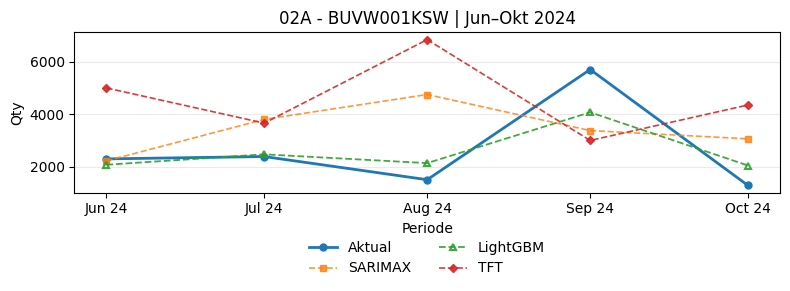


=== Plot 05A-BUVW001KSW ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__05A__BUVW001KSW.png


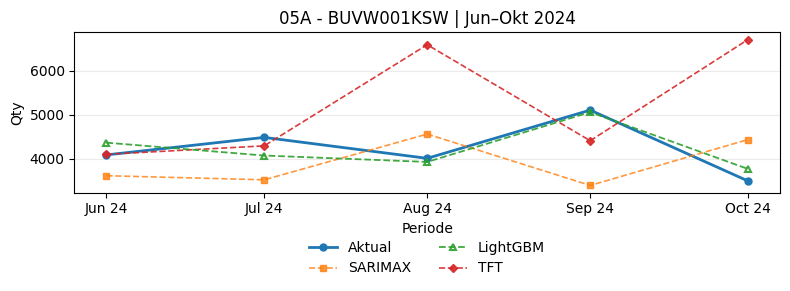


=== Plot 13A-DOPQ001K002 ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__13A__DOPQ001K002.png


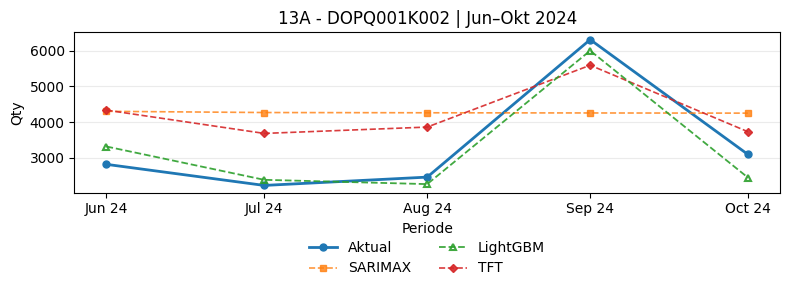


=== Plot 13I-BUVW001KSW ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__13I__BUVW001KSW.png


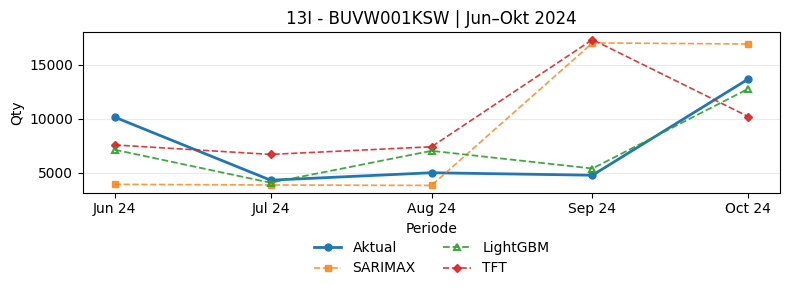


=== Plot 14A-BUVW001KSW ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__14A__BUVW001KSW.png


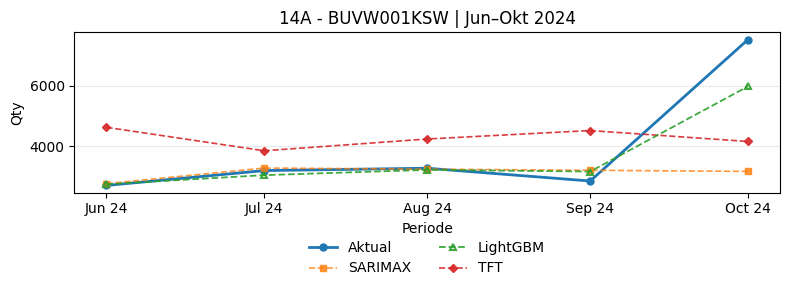


=== Plot 16C-DOPQ001K009 ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__16C__DOPQ001K009.png


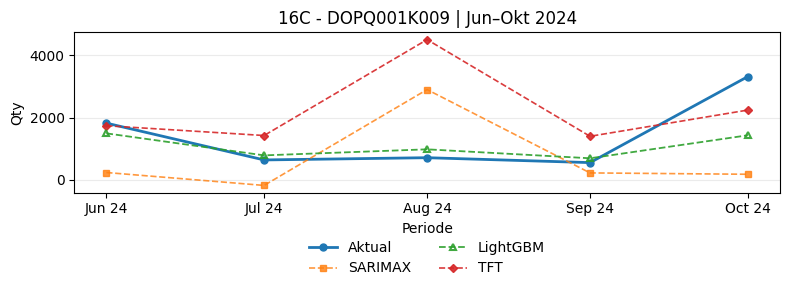


=== Plot 17A-DOPQ001K002 ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__17A__DOPQ001K002.png


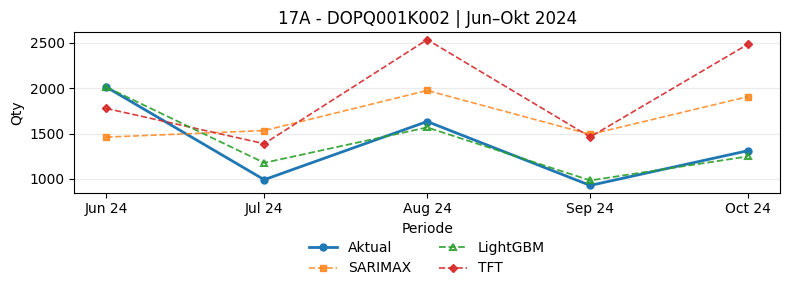


=== Plot 23A-BUVW001KSW ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__23A__BUVW001KSW.png


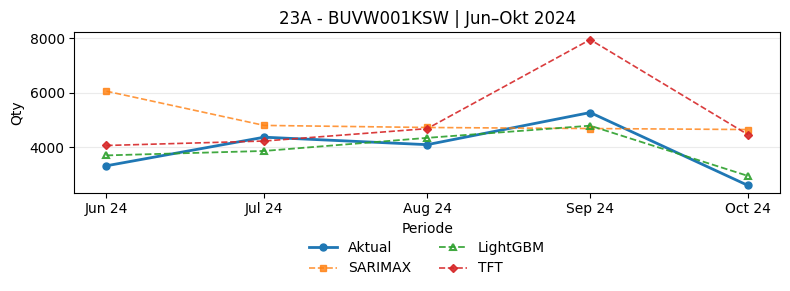


=== Plot 29A-BUVW001KSW ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_plots\compare_actual_3model__29A__BUVW001KSW.png


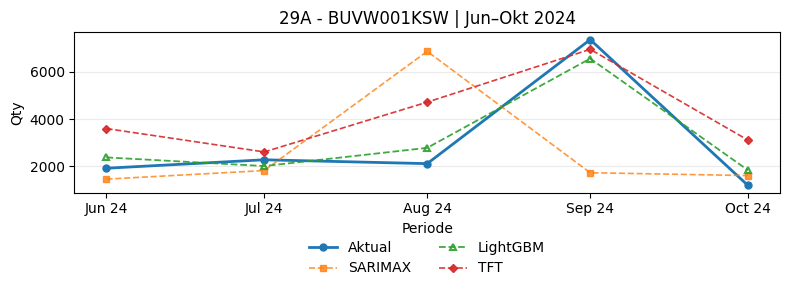

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")

sarimax_pred_path = PROJECT_ROOT / "outputs" / "sarimax_15_level_trainselect" / "sarimax_15_level_trainselect_predictions.csv"
lgbm_pred_path   = PROJECT_ROOT / "outputs" / "lgbm_15_clusters_tweedie_noleak" / "panel_with_predictions.csv"
tft_pred_path    = PROJECT_ROOT / "outputs" / "tft_15sku_log_test_predictions_optuna.csv"

sarimax_df = pd.read_csv(sarimax_pred_path, parse_dates=["periode"])
lgbm_df    = pd.read_csv(lgbm_pred_path,   parse_dates=["periode"])
tft_df     = pd.read_csv(tft_pred_path,    parse_dates=["periode"])

if "pred" not in sarimax_df.columns:
    raise ValueError("SARIMAX: kolom 'pred' tidak ditemukan.")
sarimax_df = sarimax_df.rename(columns={"pred": "pred_sarimax"})

if "pred_qty" not in lgbm_df.columns:
    raise ValueError("LGBM: kolom 'pred_qty' tidak ditemukan di panel_with_predictions.csv.")
lgbm_df = lgbm_df.rename(columns={"pred_qty": "pred_lgbm"})

if "qty_pred" not in tft_df.columns:
    raise ValueError("TFT: kolom 'qty_pred' tidak ditemukan di tft_15sku_log_test_predictions_optuna.csv.")
tft_df  = tft_df.rename(columns={"qty_pred": "pred_tft"})

for df_ in [sarimax_df, lgbm_df, tft_df]:
    if "cabang" not in df_.columns or "sku" not in df_.columns:
        raise ValueError("Semua file prediksi harus punya kolom 'cabang' dan 'sku'.")

def plot_compare_series(cabang: str, sku: str, out_dir: Path = None, show: bool = True):
    if out_dir is None:
        out_dir = PROJECT_ROOT / "outputs" / "model_eval_plots"
    out_dir.mkdir(parents=True, exist_ok=True)
    s_sar = sarimax_df[(sarimax_df["cabang"] == cabang) & (sarimax_df["sku"] == sku)].copy()
    s_lgb = lgbm_df[(lgbm_df["cabang"] == cabang) & (lgbm_df["sku"] == sku)].copy()
    s_tft = tft_df[(tft_df["cabang"] == cabang) & (tft_df["sku"] == sku)].copy()

    if s_sar.empty and s_lgb.empty and s_tft.empty:
        print(f"[SKIP] {cabang}-{sku}: tidak ada prediksi")
        return
    if not s_lgb.empty:
        base = s_lgb[["periode", "qty"]].copy()
    elif not s_tft.empty:
        base = s_tft[["periode", "qty"]].copy()
    else:
        base = s_sar[["periode", "qty"]].copy()

    base = base.drop_duplicates(subset=["periode"]).sort_values("periode")

    base = (
        base.merge(
            s_sar[["periode", "pred_sarimax"]],
            on="periode", how="left"
        )
        .merge(
            s_lgb[["periode", "pred_lgbm"]],
            on="periode", how="left"
        )
        .merge(
            s_tft[["periode", "pred_tft"]],
            on="periode", how="left"
        )
    )
    mask_test_window = (base["periode"] >= "2024-06-01") & (base["periode"] <= "2024-10-31")
    base = base[mask_test_window]

    if base.empty:
        print(f"[SKIP] {cabang}-{sku}: tidak ada data test Jun–Okt 2024")
        return

    fig, ax = plt.subplots(figsize=(8, 3.2))

    locator = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    ax.plot(
        base["periode"], base["qty"],
        marker="o",
        linewidth=2.0,
        markersize=5,
        label="Aktual",
    )

    if base["pred_sarimax"].notna().any():
        ax.plot(
            base["periode"], base["pred_sarimax"],
            marker="s",
            linestyle="--",
            linewidth=1.2,
            markersize=4,
            alpha=0.8,
            label="SARIMAX",
        )

    if base["pred_lgbm"].notna().any():
        ax.plot(
            base["periode"], base["pred_lgbm"],
            marker="^",
            linestyle="--",
            linewidth=1.3,
            markersize=5,
            markerfacecolor="none",
            markeredgewidth=1.5,
            alpha=0.9,
            label="LightGBM",
            zorder=4,
        )

    if base["pred_tft"].notna().any():
        ax.plot(
            base["periode"], base["pred_tft"],
            marker="D",
            linestyle="--",
            linewidth=1.2,
            markersize=4,
            alpha=0.9,
            label="TFT",
        )

    ax.set_title(f"{cabang} - {sku} | Jun–Okt 2024")
    ax.set_xlabel("Periode")
    ax.set_ylabel("Qty")
    ax.grid(True, axis="y", alpha=0.25)

    plt.tight_layout(rect=[0, 0.2, 1, 1])
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=2,
        frameon=False,
    )

    out_path = out_dir / f"compare_actual_3model__{cabang}__{sku}.png"
    fig.savefig(out_path, dpi=200)
    print("Saved:", out_path)

    if show:
        plt.show()
    else:
        plt.close(fig)

test_pairs = (
    lgbm_df[lgbm_df["is_test"] == 1][["cabang", "sku"]]
    .drop_duplicates()
    .sort_values(["cabang", "sku"])
    .itertuples(index=False, name=None)
)

for cab, sku in test_pairs:
    print(f"\n=== Plot {cab}-{sku} ===")
    plot_compare_series(cab, sku, show=True)


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")

DATASET15_DIR = PROJECT_ROOT / "data" / "dataset_15"
EXT_DIR       = PROJECT_ROOT / "data" / "external"

SARIMAX_DIR   = PROJECT_ROOT / "outputs" / "sarimax_15_log_trainselect"
LGBM_DIR      = PROJECT_ROOT / "outputs" / "lgbm_15_clusters_tweedie_noleak"
TFT_DIR       = PROJECT_ROOT / "outputs"

OUT_DIR       = PROJECT_ROOT / "outputs" / "model_eval_4models"
OUT_DIR.mkdir(parents=True, exist_ok=True)

panel15_path = DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv"
if panel15_path.exists():
    panel15 = pd.read_csv(panel15_path, usecols=["area", "cabang", "sku"]).drop_duplicates()
else:
    panel15 = pd.DataFrame(columns=["area", "cabang", "sku"])

def attach_area(df: pd.DataFrame) -> pd.DataFrame:
    if panel15.empty:
        out = df.copy()
        if "area" not in out.columns:
            out["area"] = np.nan
        return out
    return df.merge(panel15, on=["cabang", "sku"], how="left")

METRICS_STD = ["MSE_test", "RMSE_test", "MAE_test", "MAPE_test"]

def _ensure_cols(df: pd.DataFrame, needed: list[str], name: str):
    miss = [c for c in needed if c not in df.columns]
    if miss:
        raise ValueError(f"[{name}] kolom hilang: {miss}. Kolom ada: {list(df.columns)}")

def norm_metrics(df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    base = df.copy()
    base["model"] = model_name

    if "area" not in base.columns:
        base["area"] = np.nan

    keep = ["area", "cabang", "sku", "model"] + METRICS_STD
    for c in METRICS_STD:
        if c in base.columns:
            base[c] = pd.to_numeric(base[c], errors="coerce")

    return base[keep]

g_metrics = None
g_path = EXT_DIR / "gichelle_sarimax_baseline.csv"
if g_path.exists():
    g_df = pd.read_csv(g_path)
    if "RMSE_test" in g_df.columns:
        tmp = g_df.copy()
        if "area" not in tmp.columns:
            tmp = attach_area(tmp)
        if "MSE_test" not in tmp.columns:
            tmp["MSE_test"] = np.nan
        if "MAE_test" not in tmp.columns:
            tmp["MAE_test"] = np.nan
        if "MAPE%_test" in tmp.columns and "MAPE_test" not in tmp.columns:
            tmp["MAPE_test"] = tmp["MAPE%_test"]
        if "MAPE_test" not in tmp.columns:
            tmp["MAPE_test"] = np.nan

        g_metrics = tmp[["area", "cabang", "sku", "MSE_test", "RMSE_test", "MAE_test", "MAPE_test"]].copy()
        g_metrics["model"] = "SARIMAX_Gichelle"
        g_metrics = norm_metrics(g_metrics, "SARIMAX_Gichelle")
    else:
        print("[WARN] gichelle_sarimax_baseline.csv ada, tapi tidak ada kolom RMSE_test. Baseline di-skip.")
else:
    print("[INFO] gichelle_sarimax_baseline.csv tidak ditemukan. Baseline di-skip.")

sar_path = SARIMAX_DIR / "sarimax_15_log_trainselect_metrics.csv"
sar_df = pd.read_csv(sar_path)

_needed_sar = ["cabang", "sku", "MSE_test", "RMSE_test", "MAE_test"]
_ensure_cols(sar_df, _needed_sar, "SARIMAX")

sar_metrics = sar_df[["cabang", "sku", "MSE_test", "RMSE_test", "MAE_test"]].copy()

if "MAPE%_test" in sar_df.columns:
    sar_metrics["MAPE_test"] = sar_df["MAPE%_test"]
elif "MAPE_test" in sar_df.columns:
    sar_metrics["MAPE_test"] = sar_df["MAPE_test"]
else:
    sar_metrics["MAPE_test"] = np.nan

sar_metrics = attach_area(sar_metrics)
sar_metrics = norm_metrics(sar_metrics, "SARIMAX")

lgbm_path = LGBM_DIR / "metrics" / "metrics_by_series_clusters_tweedie_noleak.csv"
lgbm_df = pd.read_csv(lgbm_path)

_needed_lgbm = ["cabang", "sku", "test_mse", "test_rmse", "test_mae"]
_ensure_cols(lgbm_df, _needed_lgbm, "LGBM")

lgbm_metrics = lgbm_df[["cabang", "sku", "test_mse", "test_rmse", "test_mae"]].copy()
lgbm_metrics = lgbm_metrics.rename(
    columns={
        "test_mse": "MSE_test",
        "test_rmse": "RMSE_test",
        "test_mae": "MAE_test",
    }
)

if "test_mape" in lgbm_df.columns:
    lgbm_metrics["MAPE_test"] = lgbm_df["test_mape"]
elif "MAPE%_test" in lgbm_df.columns:
    lgbm_metrics["MAPE_test"] = lgbm_df["MAPE%_test"]
else:
    lgbm_metrics["MAPE_test"] = np.nan

lgbm_metrics = attach_area(lgbm_metrics)
lgbm_metrics = norm_metrics(lgbm_metrics, "LGBM")

tft_path = TFT_DIR / "tft_15sku_log_metrics_by_series_optuna.csv"
tft_df = pd.read_csv(tft_path)

_needed_tft = ["cabang", "sku", "MSE_test", "RMSE_test", "MAE_test"]
_ensure_cols(tft_df, _needed_tft, "TFT")

tft_metrics = tft_df[["cabang", "sku", "MSE_test", "RMSE_test", "MAE_test"]].copy()
if "MAPE%_test" in tft_df.columns:
    tft_metrics["MAPE_test"] = tft_df["MAPE%_test"]
elif "MAPE_test" in tft_df.columns:
    tft_metrics["MAPE_test"] = tft_df["MAPE_test"]
else:
    tft_metrics["MAPE_test"] = np.nan

tft_metrics = attach_area(tft_metrics)
tft_metrics = norm_metrics(tft_metrics, "TFT")

frames = []
if g_metrics is not None:
    frames.append(g_metrics)
frames += [sar_metrics, lgbm_metrics, tft_metrics]

all_metrics = pd.concat(frames, ignore_index=True)

all_metrics["cabang"] = all_metrics["cabang"].astype(str).str.strip().str.upper()
all_metrics["sku"]    = all_metrics["sku"].astype(str).str.strip().str.upper()

all_metrics["n_metrics_nonnull"] = all_metrics[METRICS_STD].notna().sum(axis=1)
all_metrics = all_metrics[all_metrics["n_metrics_nonnull"] > 0].drop(columns=["n_metrics_nonnull"]).reset_index(drop=True)

def best_per_metric(df_long: pd.DataFrame, metric_col: str) -> pd.DataFrame:
    tmp = df_long.dropna(subset=[metric_col]).copy()
    if tmp.empty:
        return pd.DataFrame(columns=["area", "cabang", "sku", f"model_best_{metric_col}", f"{metric_col}_best"])
    out = (
        tmp.sort_values(["cabang", "sku", metric_col])
           .groupby(["cabang", "sku"], as_index=False)
           .first()
    )
    out = out.rename(columns={"model": f"model_best_{metric_col}", metric_col: f"{metric_col}_best"})
    keep = ["area", "cabang", "sku", f"model_best_{metric_col}", f"{metric_col}_best"]
    for c in keep:
        if c not in out.columns:
            out[c] = np.nan
    return out[keep]

best_mse  = best_per_metric(all_metrics, "MSE_test")
best_rmse = best_per_metric(all_metrics, "RMSE_test")
best_mae  = best_per_metric(all_metrics, "MAE_test")
best_mape = best_per_metric(all_metrics, "MAPE_test")

best_all = best_mse.merge(best_rmse, on=["area", "cabang", "sku"], how="outer")
best_all = best_all.merge(best_mae,  on=["area", "cabang", "sku"], how="outer")
best_all = best_all.merge(best_mape, on=["area", "cabang", "sku"], how="outer")

def pivot_metric(df_long: pd.DataFrame, metric_col: str) -> pd.DataFrame:
    piv = (
        df_long.pivot_table(
            index=["area", "cabang", "sku"],
            columns="model",
            values=metric_col,
            aggfunc="first"
        )
        .reset_index()
    )
    return piv

pivot_mse  = pivot_metric(all_metrics, "MSE_test")
pivot_rmse = pivot_metric(all_metrics, "RMSE_test")
pivot_mae  = pivot_metric(all_metrics, "MAE_test")
pivot_mape = pivot_metric(all_metrics, "MAPE_test")

combo_mse  = pivot_mse.merge(best_mse,  on=["area", "cabang", "sku"], how="left")
combo_rmse = pivot_rmse.merge(best_rmse, on=["area", "cabang", "sku"], how="left")
combo_mae  = pivot_mae.merge(best_mae,  on=["area", "cabang", "sku"], how="left")
combo_mape = pivot_mape.merge(best_mape, on=["area", "cabang", "sku"], how="left")

long_path     = OUT_DIR / "model_eval_4models_long_4metrics.csv"
best_path     = OUT_DIR / "model_eval_4models_best_per_series_4metrics.csv"

mse_path      = OUT_DIR / "model_eval_4models_mse_pivot.csv"
rmse_path     = OUT_DIR / "model_eval_4models_rmse_pivot.csv"
mae_path      = OUT_DIR / "model_eval_4models_mae_pivot.csv"
mape_path     = OUT_DIR / "model_eval_4models_mape_pivot.csv"

combo_mse_path  = OUT_DIR / "model_eval_4models_mse_plus_winner.csv"
combo_rmse_path = OUT_DIR / "model_eval_4models_rmse_plus_winner.csv"
combo_mae_path  = OUT_DIR / "model_eval_4models_mae_plus_winner.csv"
combo_mape_path = OUT_DIR / "model_eval_4models_mape_plus_winner.csv"

all_metrics.to_csv(long_path, index=False)
best_all.to_csv(best_path, index=False)

pivot_mse.to_csv(mse_path, index=False)
pivot_rmse.to_csv(rmse_path, index=False)
pivot_mae.to_csv(mae_path, index=False)
pivot_mape.to_csv(mape_path, index=False)

combo_mse.to_csv(combo_mse_path, index=False)
combo_rmse.to_csv(combo_rmse_path, index=False)
combo_mae.to_csv(combo_mae_path, index=False)
combo_mape.to_csv(combo_mape_path, index=False)

print("Saved long (4 metrics)                 ->", long_path)
print("Saved best per series (4 metrics)      ->", best_path)
print("Saved pivot MSE                        ->", mse_path)
print("Saved pivot RMSE                       ->", rmse_path)
print("Saved pivot MAE                        ->", mae_path)
print("Saved pivot MAPE                       ->", mape_path)
print("Saved MSE + winner                     ->", combo_mse_path)
print("Saved RMSE + winner                    ->", combo_rmse_path)
print("Saved MAE + winner                     ->", combo_mae_path)
print("Saved MAPE + winner                    ->", combo_mape_path)

print("\nContoh 10 baris: RMSE pivot + pemenang")
print(combo_rmse.head(10).to_string(index=False))

print("\nContoh 10 baris: MAPE pivot + pemenang")
print(combo_mape.head(10).to_string(index=False))


Saved long (4 metrics)                 -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_long_4metrics.csv
Saved best per series (4 metrics)      -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_best_per_series_4metrics.csv
Saved pivot MSE                        -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_mse_pivot.csv
Saved pivot RMSE                       -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_rmse_pivot.csv
Saved pivot MAE                        -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_mae_pivot.csv
Saved pivot MAPE                       -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models_mape_pivot.csv
Saved MSE + winner                     -> D:\Documents\Skripsi\demand-forecasting\outputs\model_eval_4models\model_eval_4models